# Own extracted img features using  9 genes and 11 img features from Gutman
35 samples <br>
Very much just feature selection!

In [2]:
%%capture
import pandas as pd
import numpy as np

# Append system path to look for additional modules (needed for rcca)
import sys
sys.path.append("/Users/kimrants/PycharmProjects/thesis_code/Thesis_code/Packages/")
sys.path.append("/Users/kimrants/PycharmProjects/thesis_code/Thesis_code/kim_code/")

# Import self-build script
import radiogenomics as r


# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.model_selection import KFold

#Plotly 
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls

import seaborn as sns
from scipy.stats.stats import pearsonr   
from sklearn.model_selection import train_test_split
import rcca
from scipy.spatial import distance_matrix
from radiomics import featureextractor

# Imports
import matplotlib.pyplot as plt
%matplotlib inline

path='/Users/kimrants/PycharmProjects/thesis_code/Thesis_code/Output_Data/OwnFeatures/9genes_11img/'

# Data
### Gene data

In [3]:
# TCGA data
df_TCGA = r.download_data("TCGA") 
df_TCGA = r.make_clean_df("TCGA", df_TCGA) # (393, 17k)

# (TP53,  PTEN,  NF1,  EGFR,  IDH1,  PIK3R1,  RB1,  PIK3CA, and  PDGFRA) as Y-block
genes = ['TP53', 'PTEN', 'NF1', 'EGFR', 'IDH1','PIK3R1','RB1','PIK3CA','PDGFRA']
df_TCGA = df_TCGA[genes]   # (393,9)

### Imaging Data (Own extracted features)

In [4]:
# Constants
NECROTIC = 1 
EDEMA = 2  
ENHANCING_TUMOR = 4

In [5]:
# Just default features (can be customised)
extractor = featureextractor.RadiomicsFeaturesExtractor()

# Download TCIA-BRaTS mapping (74 samples)
mapping = r.download_data("BRATS_TCIA_MATCHES")

# Get paths to BRaTS-TCIA subjects in HHG folder and build nested dict (74 subjects)
num_subjects, dict_paths = r.nested_dict_folder_paths()

In [6]:
# Extract features
extract_feature = False
if extract_feature:
    # Pass in extractor + dictionary_paths
    dict_features = r.nested_dict_features(extractor, dict_paths)
    np.save(path + "dict_extracted_features_74samples_onlyDefaultFeatures", dict_features)
else: 
    dict_features = np.load(path + "dict_extracted_features_74samples_onlyDefaultFeatures" + ".npy").item()
    
df_TCIA = r.make_replication_study_df(dict_features)

# Analysis
## Correlation of image features (Do I need significance here as well? or is it fine?)

Text(0.5,1,'Volume Correlations \n Sample:74')

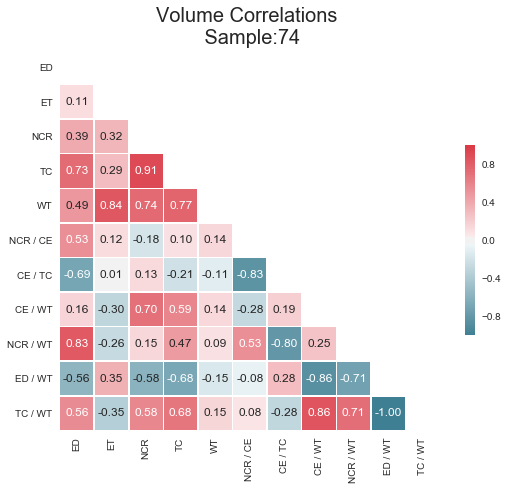

In [6]:
# Set style
sns.set(style="white")

# Compute the correlation matrix
corr = df_TCIA.corr() # TCIA = (102,11)
corr.index = ['ED', 'ET', 'NCR', 'TC', 'WT', 'NCR / CE', 'CE / TC', 'CE / WT', 'NCR / WT','ED / WT','TC / WT']
corr.columns = ['ED', 'ET', 'NCR', 'TC', 'WT', 'NCR / CE', 'CE / TC', 'CE / WT', 'NCR / WT','ED / WT','TC / WT']


# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, fmt='.2f', annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title("Volume Correlations \n Sample:" +str(df_TCIA.shape[0]), size=20)

### Only matches
35 samples

In [9]:
# Apply AFTER correlation analysis
matches = r.find_matches(df_TCGA, df_TCIA)
df_TCIA = df_TCIA.loc[matches,:].astype(float) # (35,11); need to turn into float
df_TCGA = df_TCGA.loc[matches,:].astype(float) # (35,9)
print(df_TCIA.shape)
print(df_TCGA.shape)

(35, 11)
(35, 9)


#  CCA - NEW

In [11]:
# Split into test and training (img=X, genes=Y)
img_train, img_test, gene_train, gene_test = train_test_split(df_TCIA, # X
                                                    df_TCGA, # Y
                                                    test_size=0.2, 
                                                    random_state=42)     # POTENTIALLLY CHANGE SEED?
print("img_train:", img_train.shape) 
print("img_test:", img_test.shape)
print("gene_train:", gene_train.shape)
print("gene_test:", gene_test.shape)

img_train: (28, 11)
img_test: (7, 11)
gene_train: (28, 9)
gene_test: (7, 9)


In [12]:
# Save data for R
img_train.to_csv(path + "img_for_R_tuning")
gene_train.to_csv(path + "gene_for_R_tuning")

In [8]:
# Load data from R - loadings
df_load_genes = pd.read_csv(path + 'R_loadings_genes')
df_load_genes = df_load_genes.set_index('Unnamed: 0', drop=True)
df_load_genes.index.name ='gene'
print(df_load_genes.shape)

df_load_img = pd.read_csv(path + 'R_loadings_img')
df_load_img = df_load_img.set_index('Unnamed: 0', drop=True)
df_load_img.index.name ='PC'
print(df_load_img.shape)

(9, 5)
(11, 5)


In [14]:
# Compute test variates
rep_var_TCIA = np.matmul(img_test.values, df_load_img.values) # Values * weights
rep_var_TCIA = StandardScaler().fit_transform(rep_var_TCIA) # Need to standardise 

# Create variates TCGA
rep_var_TCGA = np.matmul(gene_test.values, df_load_genes.values)
rep_var_TCGA = StandardScaler().fit_transform(rep_var_TCGA) # Need to standardise 

# DataFrames
df_rep_var_TCIA = pd.DataFrame(data=rep_var_TCIA)
df_rep_var_TCGA = pd.DataFrame(data=rep_var_TCGA)

In [15]:
# Correlation 
test_corr = [np.corrcoef(df_rep_var_TCIA.iloc[:,0], df_rep_var_TCGA.iloc[:,0])[0][1],
             np.corrcoef(df_rep_var_TCIA.iloc[:,1], df_rep_var_TCGA.iloc[:,1])[0][1],
             np.corrcoef(df_rep_var_TCIA.iloc[:,2], df_rep_var_TCGA.iloc[:,2])[0][1],
             np.corrcoef(df_rep_var_TCIA.iloc[:,3], df_rep_var_TCGA.iloc[:,3])[0][1],
             np.corrcoef(df_rep_var_TCIA.iloc[:,4], df_rep_var_TCGA.iloc[:,4])[0][1]]
test_corr

[0.6073156924693913,
 -0.01854364185695708,
 0.22889937091770488,
 0.878428495569374,
 0.4055131158470868]

In [16]:
# Plot just histogram
data_scree = r.plotly_scree_CCA(test_corr)

# Plot layout
layout=Layout(
        yaxis=YAxis(title='Canonical Correlation'),
        title='Canonical Correlation Analysis')

fig_scre = Figure(data=data_scree, layout=layout)
py.iplot(fig_scre)

### New "test" of test set
Doesn't matter that there is overlap to the other... we don't estimate model performance from this, just to see the amount of variance

In [17]:
d={}
kf = KFold(n_splits=5, random_state=None, shuffle=False)

i = 1
for tr_ind, tst_ind in kf.split(df_TCIA):
    img_train, img_test = df_TCIA.iloc[tr_ind,], df_TCIA.iloc[tst_ind]
    gene_train, gene_test = df_TCGA.iloc[tr_ind], df_TCGA.iloc[tst_ind]
    # Save data for R
    img_train.to_csv(path + "img_for_R_tuning_"+str(i))
    gene_train.to_csv(path + "gene_for_R_tuning_"+str(i))
    d['img_test_'+str(i)] = img_test
    d['genes_test_'+str(i)] = gene_test
    i += 1

In [19]:
# Load data from R - loadings
for i in range(1,6):
    df_lambd1 = pd.read_csv(path + 'R_optLambda1_' + str(i))
    d['lamda1_'+str(i)] = df_lambd1.loc[0,'x']
    
    df_lambd2 = pd.read_csv(path + 'R_optLambda2_' + str(i))
    d['lamda2_'+str(i)] = df_lambd2.loc[0,'x']
    
    df_load_genes = pd.read_csv(path + 'R_loadings_genes_'+str(i))
    df_load_genes = df_load_genes.set_index('Unnamed: 0', drop=True)
    df_load_genes.index.name ='gene'
    d['df_genes_'+str(i)] = df_load_genes
    print(d['df_genes_'+str(i)].shape)
    
    df_load_img = pd.read_csv(path + 'R_loadings_img')
    df_load_img = df_load_img.set_index('Unnamed: 0', drop=True)
    df_load_img.index.name ='PC'
    d['df_img_'+str(i)] = df_load_img
    print(d['df_img_'+str(i)].shape)

    # Compute test variates
    rep_var_TCIA = np.matmul(d['img_test_'+str(i)].values, d['df_img_'+str(i)].values) # Values * weights
    rep_var_TCIA = StandardScaler().fit_transform(rep_var_TCIA) # Need to standardise 

    # Create variates TCGA
    rep_var_TCGA = np.matmul(d['genes_test_'+str(i)].values, d['df_genes_'+str(i)].values)
    rep_var_TCGA = StandardScaler().fit_transform(rep_var_TCGA) # Need to standardise 

    # DataFrames
    df_rep_var_TCIA = pd.DataFrame(data=rep_var_TCIA)
    df_rep_var_TCGA = pd.DataFrame(data=rep_var_TCGA)
    
    # Correlation 
    test_corr = [np.corrcoef(df_rep_var_TCIA.iloc[:,0], df_rep_var_TCGA.iloc[:,0])[0][1],
             np.corrcoef(df_rep_var_TCIA.iloc[:,1], df_rep_var_TCGA.iloc[:,1])[0][1],
             np.corrcoef(df_rep_var_TCIA.iloc[:,2], df_rep_var_TCGA.iloc[:,2])[0][1],
             np.corrcoef(df_rep_var_TCIA.iloc[:,3], df_rep_var_TCGA.iloc[:,3])[0][1],
             np.corrcoef(df_rep_var_TCIA.iloc[:,4], df_rep_var_TCGA.iloc[:,4])[0][1]]
    d['test_corr_'+str(i)] = test_corr
    
    df_cv = pd.read_csv(path + 'R_rCCA_CV_'+str(i))
    df_cv.drop('Unnamed: 0', inplace=True, axis=1)
    d['max_cv_'+str(i)] = df_cv.max().max().round(4)

(9, 5)
(11, 5)
(9, 5)
(11, 5)
(9, 5)
(11, 5)
(9, 5)
(11, 5)
(9, 5)
(11, 5)


In [20]:
indeces = [i for i in range(1,6)]
columns = ['test_corr_cc1', 'CV-score','Reg1','Reg2']

# Make data
data = []
for i in range(1,6):
    inner = []
    inner.append(d['test_corr_'+str(i)][0])
    inner.append(d['max_cv_'+str(i)])
    inner.append(d['lamda1_'+str(i)])
    inner.append(d['lamda2_'+str(i)])
    data.append(inner)

# Make DF
df_overview = pd.DataFrame(data=data, index=indeces, columns=columns)

In [21]:
df_overview

test_corr_cc1  CV-score      Reg1      Reg2
1       0.260360    0.3834  1.500000  0.000100
2       0.100503    0.1912  0.315868  0.236926
3       0.264155    0.6635  0.079042  0.000100
4       0.069998    0.5756  1.500000  0.079042
5       0.920261    0.3116  0.079042  0.000100

### Look inside first canonical pair for genes and imaging respectively (img first, then genes)
I have not made it relative weights! i.e. I have not said w_i / w_sum

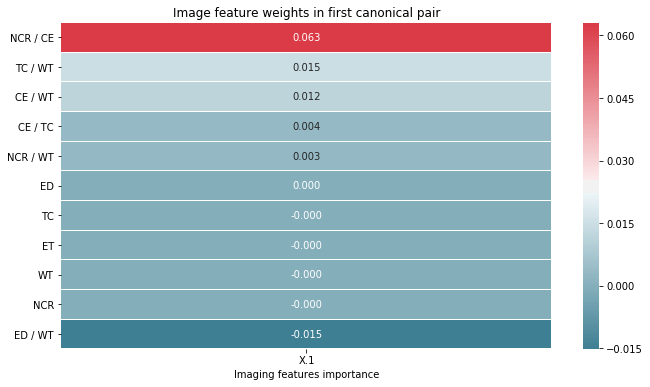

In [9]:
# set GLOBAL decimal precision
pd.set_option('display.float_format', lambda x: '%.4f' % x)

indeces = ['ED', 'ET', 'NCR', 'TC', 'WT', 'NCR / CE', 'CE / TC', 'CE / WT', 'NCR / WT','ED / WT','TC / WT']

# Sort
df_load_img.index = indeces
df_load_img = df_load_img.sort_values(by=['X.1'], ascending=False) 
df = df_load_img.drop(['X.2', 'X.3', 'X.4', 'X.5'], axis=1)
df.columns.name = 'Imaging features importance'

# Plot- Construct cmap
my_cmap = sns.light_palette("Navy", as_cmap=True)
my_cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot
plt.figure(figsize=(11,6))
plt.title('Image feature weights in first canonical pair')
sns.heatmap(df, cmap=my_cmap, annot=True, fmt='.3f', linewidths=0.1)

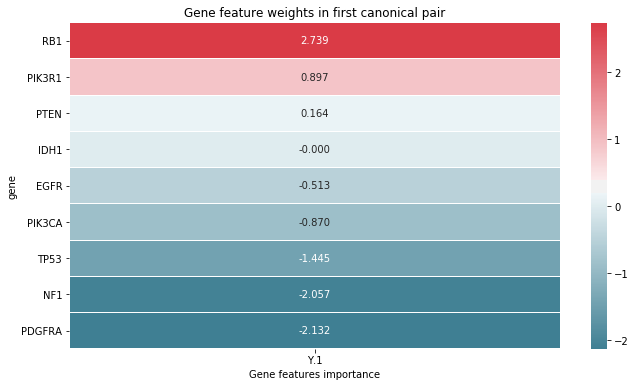

In [10]:
# Sort
df_load_genes = df_load_genes.sort_values(by=['Y.1'], ascending=False) 
df = df_load_genes.drop(['Y.2', 'Y.3', 'Y.4', 'Y.5'], axis=1)
df.columns.name = 'Gene features importance'

# Plot- Construct cmap
my_cmap = sns.light_palette("Navy", as_cmap=True)
my_cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot
plt.figure(figsize=(11,6))
plt.title('Gene feature weights in first canonical pair')
sns.heatmap(df, cmap=my_cmap, annot=True, fmt='.3f', linewidths=0.1)

# CV: Do again!
### Validation- R (35 subjects!)
# Good results!
Problem: I really shouldn't need to use regularisation here, but I do?<br>
Don't understand why high regularisation is optimal?

In [12]:
# Save
print(df_TCIA.shape)
print(df_TCGA.shape)
df_TCIA.to_csv(path+"TCIA_(35,9)")
df_TCGA.to_csv(path+"TCGA_(35,11)")

(35, 11)
(35, 9)


In [15]:
# Load 
df_cv = pd.read_csv('/Users/kimrants/PycharmProjects/thesis_code/Thesis_code/Output_Data/OwnFeatures/9genes_11img/R_rCCA_CV')
grid = pd.read_csv('/Users/kimrants/PycharmProjects/thesis_code/Thesis_code/Output_Data/OwnFeatures/9genes_11img/R_rCCA_grid')

# Get index list, round to 4 decimals
index_list = list(grid['x'])
index_list = [ '%.4f' % elem for elem in index_list ]

# Drop current "index"
df_cv.drop('Unnamed: 0', inplace=True, axis=1)

# set rows and columns (symmetric)
df_cv.index = index_list
df_cv.columns = index_list

# Find max and related index/columns
max_score = df_cv.iloc[0,0]
index = list(df_cv.index)[0]
col = list(df_cv.columns)[0]

for index_row, row in df_cv.iterrows():
    for index_column, dist in row.iteritems():
        if df_cv.loc[index_row,index_column] > max_score:
            max_score = df_cv.loc[index_row,index_column]
            index = index_row
            col = index_column
print("Max_socre is: ", max_score)
print(df_cv.max().max().round(4))

Max_socre is:  0.542770264334526
0.5428


[Text(34,0.5,'Lambda1'), Text(0.5,16,'Lambda2')]

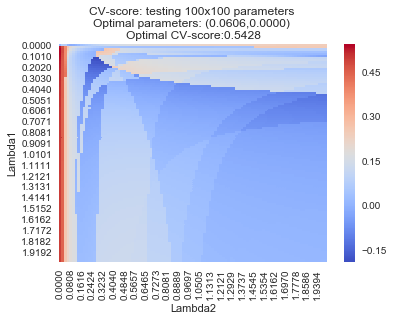

In [24]:
# MAKE SURE THAT INDEX/COL is CORRECT WITH LAMBDA1 / LAMBDA2
fig = sns.heatmap(df_cv, cmap="coolwarm")
fig.set_title("CV-score: testing " + str(len(index_list))+"x" + str(len(index_list)) + " parameters \n" + 
             "Optimal parameters: (" +  index + "," + col +") \n" +
             "Optimal CV-score:" + str(max_score.round(4)))
fig.set(xlabel='Lambda2', ylabel='Lambda1')

## t-SNE (35 subjects) BUT CURRENTLY JUST 30!!! FIX THIS!
### Generate data for Dash

In [25]:
# DELETE THIS STEP ONCE PAUL FIXES!
df_53subjects = r.download_directly('53subjects')
df_TCIA = df_TCIA.filter(list(df_53subjects.index), axis='index') # (30,11)

In [26]:
# Add additional columns
# Get df of gene groups (number represents mutations)
df_gene_groups = r.df_gene_groups()
df_gene_groups = df_gene_groups.filter(list(df_TCIA.index), axis='index')

# Get gene data and prim vs. secondary + groupings to send more complete data to dash
df_TCGA = df_TCGA.filter(list(df_TCIA.index), axis='index')
df_prim_sec = r.get_prim_sec_from_idh1(df_TCGA)

# combine first
df_to_add = r.add_info(df_gene_groups, df_prim_sec.T.values.tolist(), df_prim_sec.columns)

# combine second
df_to_add = r.add_info(df_to_add, df_TCGA.T.values.tolist(), df_TCGA.columns) #(30,33)

In [27]:
run = False
if run:
    r.Dash_tsne_no_PCA(df_TCIA, df_to_add, path)        

### t-SNE association algorithm
Neighbours only. Ignore threshold to start

In [28]:
# Create distance matrix when only 9 genes considered 
df_TCGA = df_TCGA.filter(list(df_53subjects.index), axis='index')
dist_mat = pd.DataFrame(data=distance_matrix(df_TCGA, df_TCGA), index=df_TCGA.index, columns=df_TCGA.index)

In [29]:
path='/Users/kimrants/PycharmProjects/thesis_code/Thesis_code/Output_Data/OwnFeatures/9genes_11img/'
# For dataFrame
columns = ['Score', 
           't-SNE dimensions', 
           'Principal Components', 
           'Perplexity', 
           'Learning Rate', 
           'k', 
           'Threshold', 
           'Corrects', 
           'Total']

# Get Results
k=5
run=False
if run:
    dict_opt_param, data = r.tsne_optimal_hyperparameters_with_threshold(ks=[k], 
                                                                         thresholds=[99999], 
                                                                         tsne_dims= r.tsne_dims, 
                                                                         PCs=['NO'], 
                                                                         perps=r.perps, 
                                                                         learn_rates=r.learn_rates,
                                                                         dist_matrix_gene=dist_mat,
                                                                         path=path)
    np.save(path+"dict_opt_param_k="+str(k)+"_thres=NO", dict_opt_param)
    df = pd.DataFrame(data=data, columns=columns) 
    df.to_csv(path + "data_opt_param_k="+str(k)+"_thres=NO")
else: 
    dict_opt_param = np.load(path +"dict_opt_param_k="+str(k)+"_thres=NO"+".npy").item()
    df = pd.read_csv(path+"data_opt_param_k="+str(k)+"_thres=NO")
    df = df.set_index('Unnamed: 0')
                

# Print info
print('\n\n')             
print("best score is", dict_opt_param['score'])
print("Possible correct: ", dict_opt_param['total'])
print("Correct: ", dict_opt_param['corrects'])
print("Dim: ", dict_opt_param['dim'])
print("PC: ", dict_opt_param['pc'])
print("Perp: ", dict_opt_param['perp'])
print("LearnRate: ", dict_opt_param['learnRate'])




best score is 0.76
Possible correct:  150
Correct:  36
Dim:  3
PC:  NO
Perp:  40
LearnRate:  200
